In [25]:
# Imports

In [27]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
# Custom modules

In [37]:
from src.utils.preprocess import (
    load_isic_data,
    get_data_generators,
    compute_class_weights
)

from src.model.model import (
    build_model,
    compile_model,
    fine_tune_model,
    get_gradcam_heatmap
)

In [39]:
# Set paths

In [41]:
data_dir = '../data/ISIC2018_Task3_Training_Input'
csv_file = '../data/ISIC2018_Task3_Training_GroundTruth.csv'

In [43]:
# load data

In [45]:
image_paths, labels, class_names = load_isic_data(data_dir, csv_file)
print(f'Classes: {class_names}')
print(f'Total images: {len(image_paths)}')

Classes: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Total images: 10015


In [47]:
# Plot class distribution

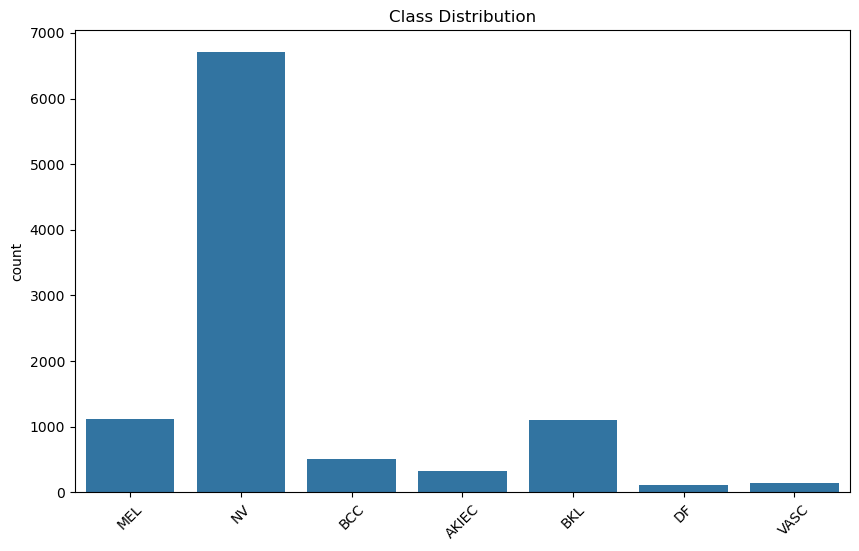

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title('Class Distribution')
plt.show()

In [51]:
# Get data generators

In [53]:
train_generator, val_generator, class_names = get_data_generators(data_dir, csv_file)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [55]:
# Compute class weights

In [57]:
class_weights = compute_class_weights(labels)

In [59]:
# Build and compile model

In [61]:
model = build_model(num_classes=len(class_names))
model = compile_model(model)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [63]:
# Train model

In [65]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('../models/skin_lesion_model.keras', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1176s 5s/step - accuracy: 0.1379 - loss: 1.9055 - val_accuracy: 0.0115 - val_loss: 1.9861
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1005s 4s/step - accuracy: 0.0626 - loss: 1.9892 - val_accuracy: 0.1098 - val_loss: 1.9525
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 872s 3s/step - accuracy: 0.0620 - loss: 1.9786 - val_accuracy: 0.0140 - val_loss: 1.9515
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - accuracy: 0.0530 - loss: 1.9080 - val_accuracy: 0.0140 - val_loss: 1.9488
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 918s 4s/step - accuracy: 0.0200 - loss: 1.8702 - val_accuracy: 0.0115 - val_loss: 1.9546
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 783s 3s/step - accuracy: 0.0290 - loss: 1.9407 - val_accuracy: 0.0115 - val_loss: 1.9570
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.0375 - loss: 1.9571 - val_accuracy: 0.0325 - val_loss: 1.9421
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 916s 4s/step - accuracy: 0.0413 - loss: 1.8840 - val_ac

In [67]:
# Fine-tune model

In [69]:
model = fine_tune_model(model, trainable_layers=10)
model = compile_model(model, learning_rate=1e-5)
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 868s 3s/step - accuracy: 0.0792 - loss: 2.0042 - val_accuracy: 0.0325 - val_loss: 1.9661
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 695s 3s/step - accuracy: 0.0975 - loss: 2.0727 - val_accuracy: 0.0325 - val_loss: 1.9538
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 715s 3s/step - accuracy: 0.1213 - loss: 2.0211 - val_accuracy: 0.0140 - val_loss: 1.9386
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.1424 - loss: 2.0088 - val_accuracy: 0.0140 - val_loss: 1.9208
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.1474 - loss: 1.8887 - val_accuracy: 0.0140 - val_loss: 1.9437
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 721s 3s/step - accuracy: 0.1155 - loss: 1.9649 - val_accuracy: 0.0140 - val_loss: 1.9517
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 772s 3s/step - accuracy: 0.1174 - loss: 1.8925 - val_accuracy: 0.0140 - val_loss: 1.9439
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 767s 3s/step - accuracy: 0.1236 - loss: 1.9700 - val_accu

In [74]:
# Evaluate model

In [ ]:
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
val_true = val_generator.classes

42/63 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step

In [ ]:
# Confusion matrix

In [ ]:
cm = confusion_matrix(val_true, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print(classification_report(val_true, val_preds_classes, target_names=class_names))

In [ ]:
# Plot training history

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Example Grad-CAM

In [ ]:
sample_img, _ = next(val_generator)
heatmap = get_gradcam_heatmap(model, sample_img[:1])
plt.imshow(sample_img[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('Grad-CAM Heatmap')
plt.show()